# QUANTUM BASTA
During the past years, it has spread the necessity of studying simple quantum systems so as to comprehend how more difficult quantum system behave and evolve. Many approaches has been used, whereas the Agassi's one has been considered very little.

QUANTUM BASTA project is based on the study of the Agassi Model, a nuclear physics approach aimed at the comprehension of the atomic nucleus behaviour. This quantum model is a combination of long range monopole-monopole and short range pairing interactions of N fermions.

The fermions are split into two different levels, each of degeneracy $\Omega$ (which is an even value). Using $\Omega$ we can define $j=\Omega /2$ which will be the parameter that indicates the particles' number considered in the simulation. 
Narrowing it down to the case where $N=2\Omega$, we obtain the relation $N=4*j$ . Another thing that is need to be said is that the two energy levels are identified by a different parity value, σ = -1 and σ = 1, while the magnetic quantum number takes the values m = ±1,...,± j (m = 0 is excluded). Thus, a single-particle state is labelled by (σ = ±,m).

For the work we relied on an article pubblicated on Physical Review B, titled "A digital quantum simulation of the Agassi model" by Pedro Pérez-Fernández (inserire link al paper). The first step consisted in duplicating the paper's results; then we proceeded with improving the code in order to get more reliability and efficiency. 

### Introduction

In [1]:
import pennylane as qml
from itertools import combinations
import networkx as nx
import numpy as np
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [2]:
print(qml.__version__)

0.40.0


### Global variables

In this very first part, all the parameters and variables used are enlisted. $j$,$ \epsilon$,$g$ and $V$ are parameters that define the hamiltonian, and so, the simulation. The others are parameters used within function and loops; each of them is appropriately commented.

In [3]:
j=1
eps=1.0
g=.6
V=3.0

v = 12#12 #initial state
n_qubits = 4*j

In [4]:
# Parameters for time evolution

t_max = 4.0            # Maximum evolution time
time_steps = 50        # Number of time intervals
n_trotter_steps = 15   # Number of Trotter steps
trotter_order = 2      # Trotter order
error_order = 1        # Order of the error scaling

# Define the time intervals
times = np.linspace(0, t_max, time_steps)

## Encoding Method

The starting point is the hamiltonian which is

$H = \epsilon J^{0} - g \sum_{\sigma = -1,1} A_{\sigma}^{\dagger} A_{\sigma} - \frac{V}{2} \left( J^+ J^- + J^- J^+ \right).$ 

For a better comprehension of the terms we refer to the article. Nevertheless, it is crucial to be said that the expression is not usable for digital simulation. It is needed a mapping into another form of the hamiltonian, the one obtained through the Jordan-Wigner trasformation. The ENCODING METHOD paragraph contains all the commands that map operators denoted by two indexes into operators named by only one index, whereas HAMILTONIAN applies the J-W trasformation.


In [5]:
def encode_indices(p, m, j):
    """
    takes two different p, m and j and  encode indexes with the specified rule, it can be used for every value of j 
    """
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

def decode_index(k, j):
    """
    Decode a single index k back into multi-indexes (p, m, j)
    """
    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m

"`encode_indices`" has the task to encode the creation and annihilator operators mapping the couple parity-magnetic quantum number $(p,m)$ into a sigle index. The variable $k$ is computated using $p,m,j$ and returns exactly the new index for the operator. As every part of the code, this paragraph is thinked for generalization of j. 

The second function is the inverse process, it helps getting back the couple $(p,m)$ using only the singular operator index. It is important to check the values ​​assumed by the parameters, which is done at the beginning of the functions.

### Test Encoding

This part has the only purpose to demonstrate how the previous functions work.

In [6]:

for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=0

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=1

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=2

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=3



## Hamiltonian

The most important part of this paragraph is the function `agassi_hamiltonian` which includes all the commands that defines the different terms of the hamiltonian. Since each term is a linear combination of operators of multiple indexes, we define new operators by using `qml.FermiA()` and `qml.FermiC()` (respectively for annihilators and creators), where we put as arguments the result of the encoding function. In this way, it is possible to obtain a more useful hamiltonian formula.  

Then, we calculate through for loop terms as $J^+$ and $J^-$, while with `A_dag()` and `A()` the second term. Summing up everything we have, we obtain an hamiltonian which can be used as the argument of the Pennylane function `qml.jordan_wigner`. Some things need to be said: the Jordan-Wigner trasformation is a map that, given as input a linear combination of fermionic annihilation and creation operators, return an equivalent expression of spin operators, which are the type of operators usable in quantum systems and quantum simulations. The fermionic operators obey anticommutation rules, whereas spin operators (thus Pauli operators) obey commutation rules. So it is needed a proper transformation. 

Using the formulas $c_i = \frac{1}{2} \left( \prod_{j=1}^{i-1} \sigma_j^z \right) (\sigma_i^x - i \sigma_i^y)$ and $c_i^\dagger = \frac{1}{2} \left( \prod_{j=1}^{i-1} \sigma_j^z \right) (\sigma_i^x + i \sigma_i^y)$, it is possible to change from these different types of operators
We then print the result of the computation.

In [7]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps, g, V):
    """
    Compute the hamiltonian expression in creation and annihilation operators, evaluating each terms of the Agassi hamiltonian.
    Every term use the mapping into single index 
    """
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms

    def A_dag(p, j):
        res = 0
        """ 
        unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        """
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res

    def A(p, j):
        res = 0
        """
        unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        """
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)


    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)

    return H

H_sec = agassi_hamiltonian(j, eps, g, V)
print("Second quantization Hamiltonian:")
print(H_sec)
print()

H_ps = qml.jordan_wigner(H_sec, ps=True, wire_map={0: 0, 1: 1, 2: 2, 3: 3})
"""
exploiting the jordan-wigner transformation
"""
# H = H.simplify()
print("Jordan-Wigner Hamiltonian:")
print(H_ps)
print()


Second quantization Hamiltonian:
-0.6 * a⁺(2) a⁺(3) a(3) a(2)
+ -0.0 * a⁺(2) a⁺(3)
+ -0.0 * a(3) a(2)
+ 0.0 * I
+ -0.6 * a⁺(2) a⁺(3) a(1) a(0)
+ -0.0 * a(1) a(0)
+ -0.6 * a⁺(0) a⁺(1) a(3) a(2)
+ -0.0 * a⁺(0) a⁺(1)
+ -0.6 * a⁺(0) a⁺(1) a(1) a(0)
+ 0.5 * a⁺(0) a(0)
+ -0.5 * a⁺(2) a(2)
+ 0.5 * a⁺(1) a(1)
+ -0.5 * a⁺(3) a(3)
+ -1.5 * a⁺(0) a(2) a⁺(0) a(2)
+ 0.0 * a⁺(0) a(2)
+ -1.5 * a⁺(0) a(2) a⁺(1) a(3)
+ 0.0 * a⁺(1) a(3)
+ -1.5 * a⁺(1) a(3) a⁺(0) a(2)
+ -1.5 * a⁺(1) a(3) a⁺(1) a(3)
+ -1.5 * a⁺(2) a(0) a⁺(2) a(0)
+ 0.0 * a⁺(2) a(0)
+ -1.5 * a⁺(2) a(0) a⁺(3) a(1)
+ 0.0 * a⁺(3) a(1)
+ -1.5 * a⁺(3) a(1) a⁺(2) a(0)
+ -1.5 * a⁺(3) a(1) a⁺(3) a(1)

Jordan-Wigner Hamiltonian:
(-0.3+0j) * I
+ (0.4+0j) * Z(2)
+ (0.4+0j) * Z(3)
+ (-0.15+0j) * Z(2) @ Z(3)
+ (-0.45+0j) * Y(2) @ X(3) @ Y(0) @ X(1)
+ (-0.45+0j) * Y(2) @ X(3) @ X(0) @ Y(1)
+ (0.45+0j) * Y(2) @ Y(3) @ X(0) @ X(1)
+ (-0.45+0j) * Y(2) @ Y(3) @ Y(0) @ Y(1)
+ (-0.45+0j) * X(2) @ X(3) @ X(0) @ X(1)
+ (0.45+0j) * X(2) @ X(3) @ Y(0) @ Y(1)
+ (-

## Determine hamiltonian components for trotterization

#### Add Implicit Terms to Hamiltonian
If Pennylane finds pauli sentences that contain null coefficients related to some pauli words, it erases automatically those terms. This can create some problems if we want to compute calculation between expressions that have different dimensions, because the code doesn't recognise the missing parts. That's why we introduce manually all the terms previously removed from the hamiltonian, exploiting `add_implicit_terms`.

In [8]:
from copy import deepcopy

def add_implicit_terms(H1_raw, n_qubits):
    """
    a copy of the hamiltonian given as an input is made, then it is done a check of the pauli words contained within the hamiltonian expression
    and if some specific pauli words have been removed by Pennlyane they're reintroduced pinned to a coefficient equals to 0.0.
    """
    H_new = deepcopy(H1_raw)
    for i in range(0, n_qubits):
        w = qml.pauli.PauliWord({i:"Z"})
        if w not in H1_raw:
            H_new[w] = 0.0
    return H_new

#### Plot Cliquets
`draw_cliquet_decomposition` is used to draw the clique graph. The necessity of adding this function was due to the fact that by default Pennylane draw graph with only shades of grey. In order to have a more comprehensible diagram, an appropriate number of different colors is generated by `generate_vibrant_colors`. Then, the graph is drawn. 

In [9]:
def draw_cliquet_decomposition(G_base, cliques):

    #plot graph with cliques

    import matplotlib.pyplot as plt
    import numpy as np

    # Define a list of colors for different cliques
    # colors = plt.cm.get_cmap("tab10", len(cliques))  # Get distinct colors
    # colors = plt.cm.get_cmap("Set1", len(cliques))  # "Set1" provides bright, distinct colors

    def generate_vibrant_colors(n_colors):
        """
        Generate a list of 'n_colors' distinct, vibrant colors while avoiding gray-like colors.
        """
        cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors
        colors = [cmap(i) for i in range(n_colors * 2)]  # Get extra colors to filter

        # Keep only highly saturated colors (skip grays)
        vibrant_colors = [color for color in colors if np.mean(color[:3]) < 0.75]  # Avoid desaturated tones

        return vibrant_colors[:n_colors]  # Return only the needed number of colors

    # Example: Generate 15 vibrant colors with no grays
    num_cliques = len(cliques)  # Arbitrary dimension
    colors = generate_vibrant_colors(num_cliques)


    # Plot the original graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G_base)  # Position nodes

    # Draw the original graph in gray (background)
    # nx.draw(G_base, pos, edgelist=[], with_labels=True, node_color="red", edge_color="red", node_size=100, font_size=10)
    nx.draw(G_base, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=50, font_size=10, alpha=0.2)


    # Draw each clique with a different color
    for i, clique in enumerate(cliques):
        nx.draw_networkx_nodes(G_base, pos, nodelist=clique, node_color=[colors[i]], node_size=200, alpha=0.5)
        nx.draw_networkx_edges(G_base, pos, edgelist=[(u, v) for u in clique for v in clique if G_base.has_edge(u, v)], edge_color=[colors[i]], width=2, alpha=0.5)

    plt.title("Original Graph with Highlighted Cliques")
    plt.show()

#### Get Cliquets
Trotterization can be done with the hamiltonian split into different terms. It is possible to find expressions of them that give a more efficient calculation of the evolution. To obtain this result, we exploite the properties of the graph's theory. The algorithm is thinked to calculate all the cliques defined by the couples pauli's operators-coefficient as nodes and commutation relation between them as links; every clique will then be a hamiltonian term. `get_hamiltonian_graph` constructs the graph considered with nodes and edges (links), `get_clique_partitioning` finds the number of cliques and identifies them, whereas `construct_hamiltonian_terms_from_cliques` reconstructs an hamiltonian expression inserting every operator with its specific coefficient.

In [10]:
def get_hamiltonian_graph(H):
    H_list = list(zip(H_ps.keys(), H.values()))
    G = nx.Graph()
    G.add_nodes_from(H_list)
    """
    We compute the hamiltonian graph, evaluating every commutator and adding, if necessary, links between terms
    """
    # Compute commutators and add edges if they commute
    for i in range(len(H_list)):
        for k in range(i + 1, len(H_list)):
            a = H_list[i][0]    #with the index[0] it takes only the first element aka the operator and it calculates the commutator
            b = H_list[k][0]    #same as above
            if len(a.commutator(b)) == 0:  # Check commutation
                G.add_edge(H_list[i], H_list[k])
    return G


def get_clique_partitioning(G, cliques, verbose=False):

    iteration = 1
    while G.number_of_nodes() > 0:
        iter_node = nx.find_cliques(G)  #automatically finds the clique
        try:
            clique = next(iter_node) #try to find another clique, if there is one advances and finds it
        except StopIteration:
            break  # If no more cliques, exit loop

        if verbose:
            print(f"Iteration {iteration}: Removing clique {clique}")

        # Remove clique from graph
        cliques.append(clique)
        G.remove_nodes_from(clique)
        iteration += 1

    if verbose:
        print("Final graph (should be empty):", G.nodes())

    return cliques


def construct_hamiltonian_terms_from_cliques(cliques):
    """
    This function reconstructs the hamiltonian terms analyzing for each clique each term contained inside of the clique and
    adding it to the array H_terms, specifying the coefficient associated
    """
    H_terms = []
    for i in range(len(cliques)):
        H_term = qml.pauli.PauliSentence()
        for k in range(len(cliques[i])):
            H_term[cliques[i][k][0]] = cliques[i][k][1]
        H_terms.append(H_term)
    return H_terms

`get_best_clique_partitioning` is thinked for evaluating the most efficient form of the cliques. This part is crucial so as to optimize as much as possible the algorithm and decrease errors in quantum simulation. The idea is the following: whenever two operators commute, it is possible to measure the two observables associated with them in parallel, without quantum interference. So we search for the partitioning that contains the highest number of commutating terms within the cliques.

 One clique at a time is removed from the graph and is computed another clique considering only the remaining nodes. It is then converted into its matrix form exploiting `construct_hamiltonian_terms_from_cliques` and it is calculated the error through the commutators between hamiltonian terms. The error is defined as the sum of the highest eigenvalues of the commutators matrix; that gives information about how much two operators commutes or don't commute. Once every possible partitioning has been explored, the one characterized by the lowest error is the one considered more efficient. 

In [11]:
# get best clique computing by computing trotter error
# At the moment this funciton finds different cliques partition starting from different initial maximal cliques

def get_best_clique_partitioning(G_base, n_qubits, error_order=1, verbose=False):
    best_cliques = None
    best_err = np.inf
    order=list(range(0,n_qubits))

    first_cliques = list(nx.find_cliques(G_base)) #list of all cliques

    def commutator_list(list1, list2):
        """create a list containing every commutator between objects belonging to the two input lists """
        commutators = []
        for i in range(len(list1)):
            for j in range(len(list2)):
                comm = qml.commutator(list1[i], list2[j], pauli=True)
                commutators.append(comm)
        return commutators

    for first_clique in first_cliques: #first_clique is a single clique contained in the list first_cliques

        G = G_base.copy()
        G.remove_nodes_from(first_clique)   #once it has been removed the i-th clique considered by the loop, 
                                            #the element remaining are manipulated so as to find a new version of the others clique
        cliques = [first_clique]
        cliques = get_clique_partitioning(G, cliques, verbose=verbose)
        commutators = []


        H_terms = construct_hamiltonian_terms_from_cliques(cliques)


        err = 0     #linalg.norm(x, ord=None, axis=None, keepdims=False)
        err1 = 0
        min_len = np.inf


        for i in range(len(H_terms)):
            clique_len = len(cliques[i])
            if clique_len < min_len:
                min_len = clique_len
            for j in range(i+1, len(H_terms)):
                first_commutator =qml.commutator(H_terms[i], H_terms[j], pauli=True)
                commutators.append(first_commutator)

        for p in range(1,error_order):  #this is used if we want to consider higher order errors, so it is reiterated the computation with commutators and H_terms

            commutators=commutator_list(H_terms, commutators)


        if error_order%2==0:            # commutator of hermitian matrices is anti-hermitian, commutator of anti hermitian and hermitian is hermitian.
            for comm in commutators:      #eigenvalsh accepts an anti hermitian
                err += np.max(np.abs(np.linalg.eigvalsh(qml.matrix(comm, wire_order=order))))
                # err += np.linalg.norm(qml.matrix(comm, wire_order=order), ord=2)

        else:
            for comm in commutators:
                err += np.max(np.abs(np.linalg.eigvalsh(-1j * qml.matrix(comm, wire_order=order))))
                # err += np.linalg.norm(qml.matrix(comm, wire_order=order), ord=2)


        print(min_len, len(H_terms), err)



        # comm = ...
        if err < best_err:
            best_err = err
            best_cliques = cliques


    print("Best error:", best_err)
    return best_cliques

At this point, it is drawn the graph, which shows all the cliques using different colors.

In [12]:
G = get_hamiltonian_graph(H_ps)
G_base = G.copy()
# cliques = get_clique_partitioning(G, verbose=True)
# H_terms = construct_hamiltonian_terms_from_cliques(cliques)

cliques = get_best_clique_partitioning(G, n_qubits, error_order=error_order, verbose=False)
H_terms = construct_hamiltonian_terms_from_cliques(cliques)
print("number of terms in hamiltonian:", len(H_terms))


7 2 7.200000000000002
4 2 7.200000000000001
Best error: 7.200000000000001
number of terms in hamiltonian: 2


/var/folders/_h/zshrjsxs42s1yscqytrdy2q00000gn/T/ipykernel_20645/1373104870.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors


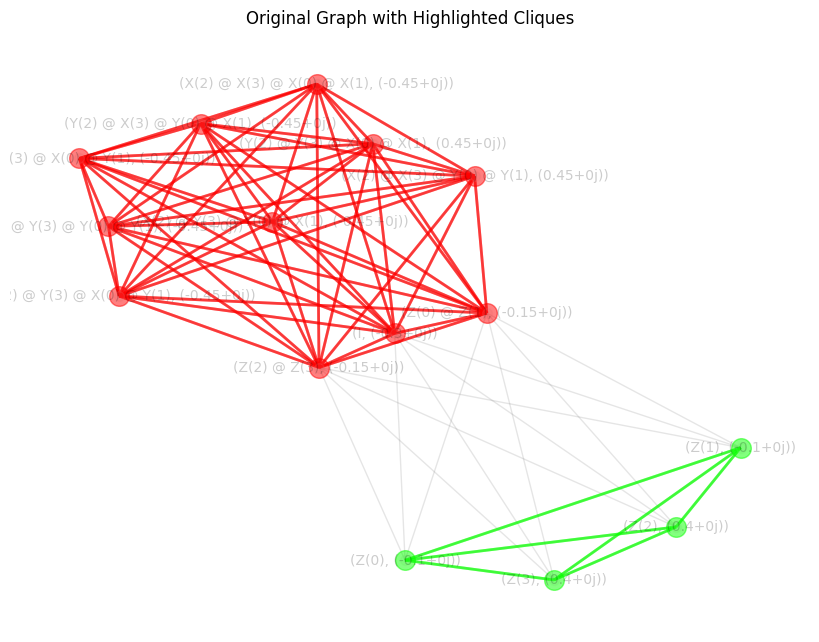

In [13]:
draw_cliquet_decomposition(G_base, cliques)

## Automatically Calculate Commutators
`test_commutativity` is used to calculate the commutators between operators contained into the hamiltonian expression, whereas `test_commutativity_between_split` evaluates the commutator between different hamiltonian terms (linear combination of operators).

In [14]:
#calculate commutators of terms in H

def test_commutativity(H):

    split_sentences1 = {}

    for pauli_word, value in H.items():
        # If this number is not already in the dictionary, initialize a new PauliSentence
        if pauli_word not in split_sentences1:
            split_sentences1[pauli_word] = qml.pauli.PauliSentence()

    # Iterate over all pairs of PauliSentences from split_sentences2 and test commutativity
    for (key1, ps1), (key2, ps2) in combinations(split_sentences1.items(), 2):
        # Compute their commutator
        comm = qml.commutator(key1,key2, pauli=True)


        # Check if they commute
        if np.allclose(comm.operation().matrix(), 0):
            # print(f"{key1} and {key2} commute.")
            # print("COMMUTE")
            pass
        else:
            print("DO NOT COMMUTE")
            # print(f"{key1} and {key2} do NOT commute.")

In [15]:
for i in range(len(H_terms)):
    test_commutativity(H_terms[i])

In [16]:
#test commutation between different split of hamiltonian

import pennylane as qml

def test_commutativity_between_split(H_terms):
    """Check commutativity of all pairs in the given list of Pauli words."""
    num_terms = len(H_terms)
    commutation_results = {}

    for i in range(num_terms):
        for j in range(i + 1, num_terms):  # Check only unique pairs (i, j)
            ps1 = H_terms[i]
            ps2 = H_terms[j]

            # Compute the commutator using PennyLane
            comm = ps1.commutator(ps2)

            # Check if the commutator is empty (i.e., they commute)
            is_commuting = len(comm) == 0
            commutation_results[(i, j)] = is_commuting

            print(f"Commutator of term {i} and term {j}: {'Commute' if is_commuting else 'Do not commute'}")
            print(comm)

    return commutation_results

commutation_results = test_commutativity_between_split(H_terms)

Commutator of term 0 and term 1: Do not commute
-0.9j * X(2) @ X(3) @ X(0) @ Y(1)
+ -0.9j * X(2) @ X(3) @ Y(0) @ X(1)
+ -0.9000000000000001j * Y(2) @ X(3) @ Y(0) @ Y(1)
+ -0.9j * X(2) @ Y(3) @ Y(0) @ Y(1)
+ 0.9000000000000001j * Y(2) @ Y(3) @ Y(0) @ X(1)
+ 0.9000000000000001j * Y(2) @ Y(3) @ X(0) @ Y(1)
+ 0.9000000000000001j * X(2) @ Y(3) @ X(0) @ X(1)
+ 0.9000000000000001j * Y(2) @ X(3) @ X(0) @ X(1)


In [17]:

# from itertools import combinations
# from pennylane.pauli import PauliSentence

# # Iterate over all pairs of PauliSentences from split_result and test commutativity
# for (num_ops1, ps1), (num_ops2, ps2) in combinations(split_result.items(), 2):
#     # Compute their commutator
#     comm = ps1.commutator(ps2)

#     # Check if they commute
#     if len(comm) == 0:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators commute.")
#     else:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators do NOT commute.")

## Time Evolution functions

### create initial state
In the following part, it is inserted inside the code the initial state that is going to be evolved with different methods, such as exact evolution or trotterization. The state is defined as an array with all zeros except for an element set to 1 at the position v, previously introduced.

In [18]:

# Initial state

dim = 2**n_qubits
initial_state = np.zeros(dim, dtype=complex)
initial_state[v] = 1

print(initial_state.shape)
print(n_qubits)

(16,)
4


### Get matrix form of hamiltonian terms
These commands have the purpose to translate hamiltonian into matrix, usable in quantum systems and simulations. Once it is determined the order of quantum bits, the hamiltonian is turned into its matrix form using `qml.matrix`, following the order just defined. Through `add_implicit_terms` we complete the expression introducing the operators that were eliminated by Pennylane. Then, we extrapolate the matrix form.

In [19]:
#get matrix form of all the hamiltonians

order = list(range(n_qubits))

for i in range(0,n_qubits):
    order[i]=i

H = qml.matrix(H_ps, wire_order=order)
"""this function give the matrix form of the hamiltonian"""
# H = get_matrix_from_ps(H_ps)

H_terms_implicit = []
for term in H_terms:
    H_terms_implicit.append(add_implicit_terms(term, n_qubits))

H_terms_mat = []
for term in H_terms_implicit: #gives the matrix form for H_terms
    # H_terms_mat.append(term.operation().matrix())
    H_terms_mat.append(qml.matrix(term, wire_order=order))


### Definition of the evolution and correlation function
It is now defined the evolution of the initial state in different ways: the first one considering an evolution due to the trotterized hamiltonian, the second one exploiting the exact evolution. The trotterization consists in evalueting the evolution of a state using a fraction of the exponential matrix of the hamiltonian which application is reiterated a number $n$ of times. As every approximation formulas, even the trotterization has infinite order that provides more and more precise result. The Suzuki-Trotter formula at the first order is:

 $e^{-i H t} \approx \left( e^{-i H_1 t / N} e^{-i H_2 t / N} \dots e^{-i H_n t / N} \right)^N$

 In the `paper_evo` function a check on the trotter order is carried out. If the trotter_order is 1, then is computed the evolution of the initial state using the various terms of the hamiltonian in turn. The evolution is carried on for a time $t/n$ and reiterated for n times. Otherwise, it is defined the trotter evolution block for the n-th order, which has to be even (the mathematical reason is that by construction the Suzuki-Trotter formula require simmetry among positive and negative commutators' terms, obtainable only with even orders). `trotter_block` distinguishes between second order and 2k-th order. In the second case, it reproduces the approximation given by 

 $S_{2k}(t) = S_{2k-2}(u_k t)^2 S_{2k-2}((1 - 4u_k)t) S_{2k-2}(u_k t)^2$ with $u_k = \frac{1}{4 - 4^{\frac{1}{2k-1}}}$. 

 As the final step, it is computed the evolution of the initial state following Suzuki-Trotter formula. Furthermore, it is defined and calculated the evolution using the exact hamiltonian. 

In [20]:


def paper_evo(t, n, trotter_order=1):

    if trotter_order == 1:
        U = np.identity(H.shape[0])
        for _ in range(0, n):
            for term in H_terms_mat:
                U = U @ expm(-1j * term * (t/n))

        evolved_state = U @ initial_state
        return evolved_state

    else:

        if trotter_order%2 == 1: raise ValueError("Trotter order must be even or 1.")

        # order 2
        def trotter_block(k, t, n):

            U = np.identity(H.shape[0])
            if k == 1:  #second order (k=trotter_order/2 with trotter_order=2)
                for i in range(len(H_terms_mat)-1):
                    term = H_terms_mat[i]
                    # print(i)
                    U = U @ expm(-0.5j * term * (t/n))

                U = U @ expm(-1j * H_terms_mat[-1] * (t/n))

                for i in range(len((H_terms_mat))-2, -1, -1):
                    term = H_terms_mat[i]
                    # print(i)
                    U = U @ expm(-0.5j * term * (t/n))

                return U

            else:   #2k-th order of the suzuki-trotter
                u_k = 1/(4-4**(1/(2*k-1)))
                a = trotter_block(k-1, u_k * t, n)
                b = a @ a
                c = trotter_block(k-1, (1 - 4*u_k) * t, n)
                U = b @ c @ b
                return U

        U = np.identity(H.shape[0])
        block = trotter_block(trotter_order/2, t, n)
        for _ in range(n):
            U = U @ block

        return U @ initial_state

# exact time evolution
def exact_evo(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t))
    evolved_state = U @ initial_state
    return evolved_state


`correlation_function` is the commands' block whose purpose is to evaluate the correlation function, which is $\sigma_z(1,2) \equiv \braket{\sigma_z^1 \sigma_z^2} - \braket{\sigma_z^1} \braket{\sigma_z^2}$. It uses the evolution of the state done with Trotter process to calculate the expectation value. 

In [21]:
#compute correlation function
def correlation_function(evo):
    i=0
    k=1
    """calculation of the correlation function for Z-Pauli operators"""
    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zk_raw = qml.pauli.PauliWord({k:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw]= 1.0
    psk = qml.pauli.PauliSentence()
    psk[Zk_raw]= 1.0

    order = list(range(n_qubits))
    for s in range(0,n_qubits):
        order[s]=s

    Zi=qml.matrix(add_implicit_terms(psi, n_qubits), wire_order=order)
    Zk=qml.matrix(add_implicit_terms(psk, n_qubits), wire_order=order)

    sigma_ik=np.vdot(evo, Zi @ Zk @ evo)-np.vdot(evo ,Zi @ evo)*np.vdot(evo,Zk @ evo)

    return sigma_ik

In [22]:
#compute correlation function
def correlation_function1( evo):
    p=1
    m=1
    p_=-1
    m_=-1
    """calculation of the correlation function for Z-Pauli operators"""
    operator_raw=qml.jordan_wigner(C_dag(p, m, j) * C_dag(p_, m_, j), ps=True)

    
    operator=add_implicit_terms(operator_raw, n_qubits).operation().matrix()

    sigma_ij_trotter=np.vdot(evo, operator @ evo)

    return sigma_ij_trotter

## FIDELITY FUNCTION
`fidelity` function is used to calculate the fidelity between two different unitary operators, which is $F(U, V) = \frac{|\text{Tr}(U^\dagger V)|}{N}$. Underneath this paragraph are computed and plotted the fidelity between exact evolution and trotterized evolution as t varies, the same as the number of trotter steps varies and also as the Suzuki-Trotter order varies (defining a better approximation).
 


In [23]:
def fidelity (U, V):
    """calculate the fidelity between 2 unitary operators"""
    if U.shape[0]==V.shape[0]:
        d = U.shape[0]
        trace = np.trace(np.dot(U.conj().T, V))  # U.dagger() è la trasposizione coniugata
        F = np.abs(trace) / d  # Fidelity normalizzata
    else:
        raise ValueError("Matrices don't have the same dimension")
    return F

### fidelity vs time

In [24]:
def trotter_block(k, t, n):
    U = np.identity(H.shape[0])
    if k == 1:  #second order (k=trotter_order/2 with trotter_order=2)
        for i in range(len(H_terms_mat)-1):
            term = H_terms_mat[i]
            # print(i)
            U = U @ expm(-0.5j * term * (t/n))

        U = U @ expm(-1j * H_terms_mat[-1] * (t/n))

        for i in range(len((H_terms_mat))-2, -1, -1):
            term = H_terms_mat[i]
            # print(i)
            U = U @ expm(-0.5j * term * (t/n))

        return U

    else:   #2k-th order of the suzuki-trotter
        u_k = 1/(4-4**(1/(2*k-1)))
        a = trotter_block(k-1, u_k * t, n)
        b = a @ a
        c = trotter_block(k-1, (1 - 4*u_k) * t, n)
        U = b @ c @ b
        return U

E = np.identity(H.shape[0])
T = np.identity(H.shape[0])
fidelityET = []
for t in times:
    E = E @ expm(-1j * H * (t))# exact evo
    block = trotter_block(trotter_order/2, t, n_trotter_steps) #Trotter evo
    for _ in range(n_trotter_steps):
        T = T @ block
    fidelityET.append(fidelity(E, T))
    #print(fidelity(E,T))

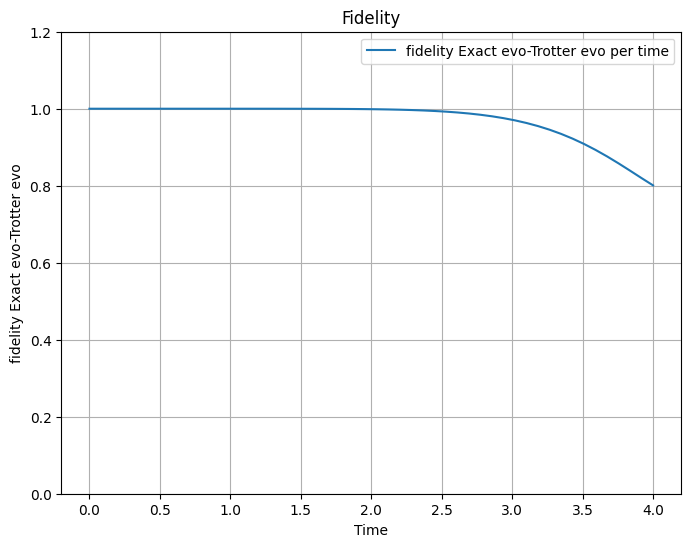

Final fidelity: 0.8008693414833779


In [25]:
plt.figure(figsize=(8, 6))
plt.plot(times, fidelityET, label="fidelity Exact evo-Trotter evo per time")
plt.xlabel("Time")
plt.ylabel("fidelity Exact evo-Trotter evo")
plt.ylim([0, 1.2])
plt.title("Fidelity")
plt.grid()
plt.legend()
plt.show()

print("Final fidelity:", fidelityET[-1])

### fidelity vs trotter steps

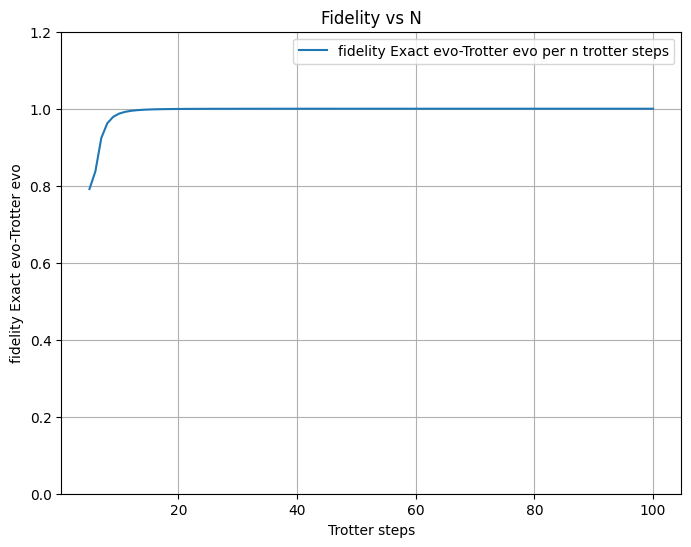

Final fidelity vs n trotter steps max: 0.9999991098043801


In [26]:
min_trotter_step = 5
max_trotter_step = 100
trotter_steps = np.arange(min_trotter_step, max_trotter_step + 1)
fidelityETvsN = []
E = np.identity(H.shape[0])
E = E @ expm(-1j * H * (t_max))# exact evo
for n in trotter_steps:
    T = np.identity(H.shape[0])
    block = trotter_block(trotter_order/2, t_max, n) #Trotter evo
    for _ in range(n):
        T = T @ block
    fidelityETvsN.append(fidelity(E, T))
plt.figure(figsize=(8, 6))
plt.plot(trotter_steps, fidelityETvsN, label="fidelity Exact evo-Trotter evo per n trotter steps")
plt.xlabel("Trotter steps")
plt.ylabel("fidelity Exact evo-Trotter evo")
plt.ylim([0, 1.2])
plt.title("Fidelity vs N")
plt.grid()
plt.legend()
plt.show()

print("Final fidelity vs n trotter steps max:", fidelityETvsN[-1])
    

### fidelity vs suzuki trotter order

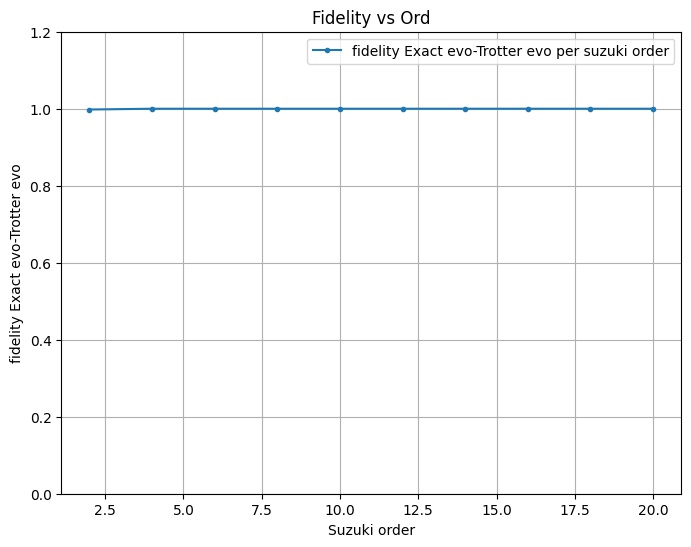

Final fidelity vs n trotter steps max: 0.9999999995125616


In [27]:
fidelityETvsOrd = []
trotter_order_max = 20
x_values = []
E = np.identity(H.shape[0])
E = E @ expm(-1j * H * (t_max))# exact evo
for o in range(1, trotter_order_max+1) :
    T = np.identity(H.shape[0])
    if o==2:
        block = trotter_block(o/2, t_max, n_trotter_steps) #Trotter evo  
        for _ in range(n_trotter_steps):
            T = T @ block
        x_values.append(o)
    elif o%2 == 1:
        continue
    else: 
        block = trotter_block(o/2, t_max, n_trotter_steps) #Trotter evo
        for _ in range(n_trotter_steps):
            T = T @ block
        x_values.append(o)
    fidelityETvsOrd.append(fidelity(E, T))

plt.figure(figsize=(8, 6))
plt.plot(x_values, fidelityETvsOrd, label="fidelity Exact evo-Trotter evo per suzuki order", marker="o", markersize=3)
plt.xlabel("Suzuki order")
plt.ylabel("fidelity Exact evo-Trotter evo")
plt.ylim([0, 1.2])
plt.title("Fidelity vs Ord")
plt.grid()
plt.legend()
plt.show()
print("Final fidelity vs n trotter steps max:", fidelityETvsOrd[-1])

### fidelity exact-trotter evo vs time (terms separated)

In [28]:
# fidelitysingle = []
# print(range(len(H_terms_mat)))
# for i in range(len(H_terms_mat)):
#     E = np.identity(H.shape[0])
#     T = np.identity(H.shape[0])
#     term = H_terms_mat[i]
#     fid_row = []
#     for t in times:
#         E = E @ expm(-1j * H * (t))# exact evo
#         for _ in range(n_trotter_steps):
#             T = T @ expm(-1j * term * (t/n_trotter_steps))
#         fid_row.append(fidelity(E,T))
#     fidelitysingle.append(fid_row)
# plt.figure(figsize=(8, 6))
# for i, fidelity in enumerate(fidelitysingle):
#     print(fidelity)
#     plt.plot(times, fidelity, label=f"fidelity Exact evo-Trotter evo {i} per suzuki order")
# plt.xlabel("Times")
# plt.ylabel("fidelity Exact evo-Trotter evo")
# plt.ylim([0, 1.2])
# plt.title("Fidelity vs times")
# plt.grid()
# plt.legend()
# plt.show()

## Compute evolution

### Paper Evolution
In this final part all the evolution are evaluated and all the overlaps between quantities of interest are plotted.

In [29]:
overlaps_paper_evo = []
correlations_trotter = []
states_paper_evo = []

# Compute the overlap with initial state
for t in times:
    result = paper_evo(t, n_trotter_steps, trotter_order=trotter_order)
    states_paper_evo.append(result)

    overlap = np.vdot(initial_state, result)
    overlap = np.abs(overlap)**2
    overlaps_paper_evo.append(overlap)

    # Compute the correlation function for trotterized evolution
    correlation_trotter = correlation_function(result)
    correlations_trotter.append(correlation_trotter)





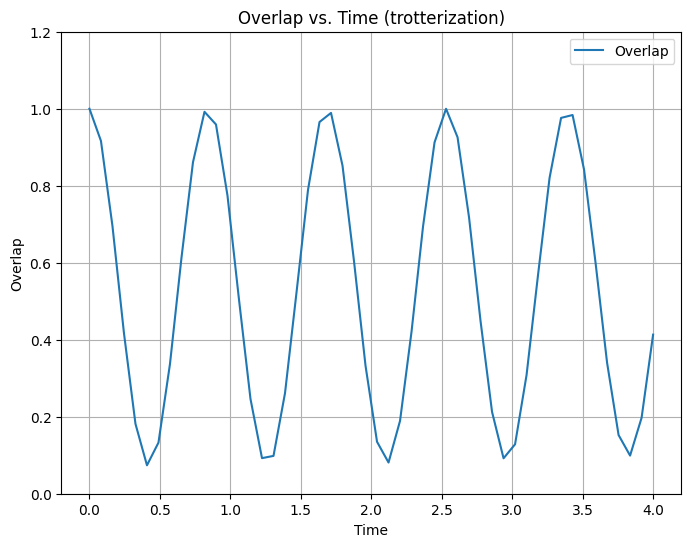

Final overlap: 0.4131925770745505


In [30]:


# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps_paper_evo, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (trotterization)")
plt.grid()
plt.legend()
plt.show()

print("Final overlap:", overlaps_paper_evo[-1])



### Exact Evolution

In [31]:

overlaps_exact_evo = []
correlations_exact = []
states_exact_evo = []

# Compute the overlap with initial state
for t in times:
    result = exact_evo(t)
    states_exact_evo.append(result)
    #result = result.numpy()  # Convert to NumPy array if required

    overlap = np.vdot(initial_state, result)
    overlap = np.abs(overlap)**2
    overlaps_exact_evo.append(overlap)

    correlation_exact = correlation_function(result)
    correlations_exact.append(correlation_exact)


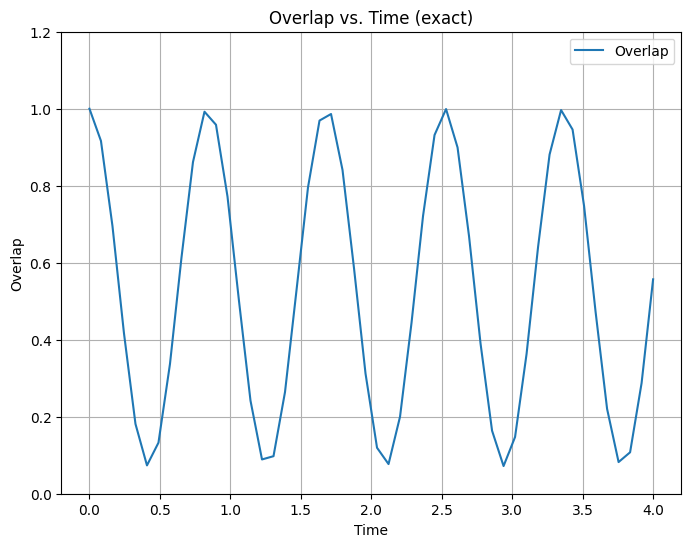

In [32]:

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps_exact_evo, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()



### Error

In [33]:
probabilities = []

# compute overlap between exact and paper evolution
for i in range(times.shape[0]):
    # evolved_state_exact = exact_evo(t)
    # evolved_state_trotter = paper_evo(t, n_trotter_steps, trotter_order=trotter_order)  # Execute the circuit
    # evolved_state_trotter = paper_evo_higher_order2(t, n_trotter_steps)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo

    # overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    overlap = np.vdot(states_exact_evo[i], states_paper_evo[i])
    probability = np.abs(overlap)**2
    probabilities.append(probability)

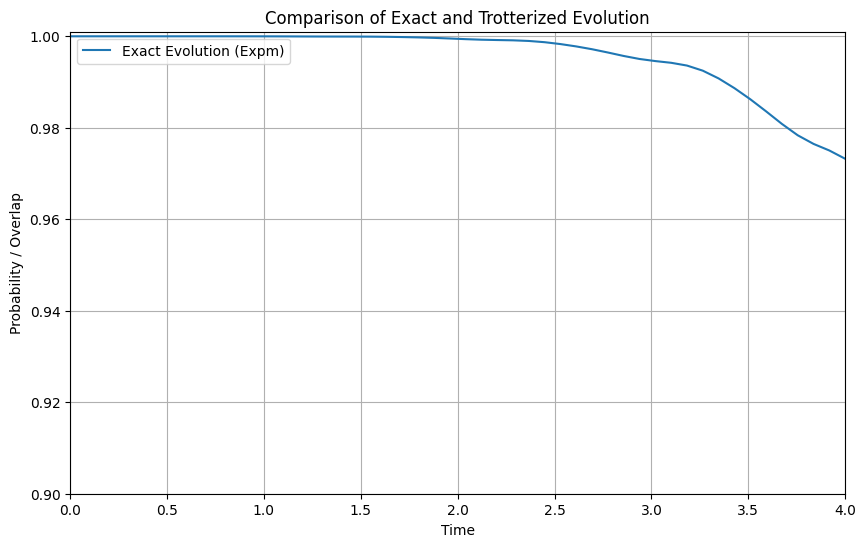

In [34]:
# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(times, probabilities, label="Exact Evolution (Expm)", markersize=3)
plt.xlabel("Time")
plt.ylabel("Probability / Overlap")
plt.xlim([0, t_max])
plt.ylim([0.90, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution")
plt.grid()
plt.legend()
plt.show()

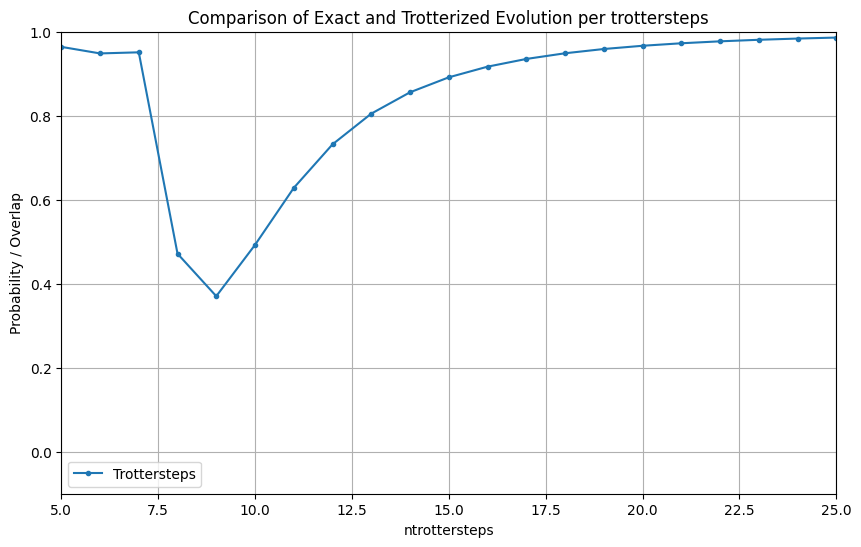

In [35]:
#comparison per number of trotter steps at given time

probabilities1 = []

min_trotter_step = 5
max_trotter_step = 25
trotter_steps = np.arange(min_trotter_step, max_trotter_step + 1)

# compute overlap between exact and paper evolution
for n in trotter_steps:
    evolved_state_exact = exact_evo(5)
    evolved_state_trotter = paper_evo(5, n, trotter_order=trotter_order)  # Execute the circuit
    # evolved_state_trotter = paper_evo_higher_order(5, n)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo

    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    probability = np.abs(overlap)**2
    probabilities1.append(probability)

# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(trotter_steps, probabilities1, label="Trottersteps", marker="o", markersize=3)
plt.xlabel("ntrottersteps")
plt.ylabel("Probability / Overlap")
plt.xlim([min_trotter_step, max_trotter_step])
plt.ylim([-0.1, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution per trottersteps")
plt.grid()
plt.legend()
plt.show()


/opt/miniconda3/envs/qubasta2/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/qubasta2/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/miniconda3/envs/qubasta2/lib/python3.11/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


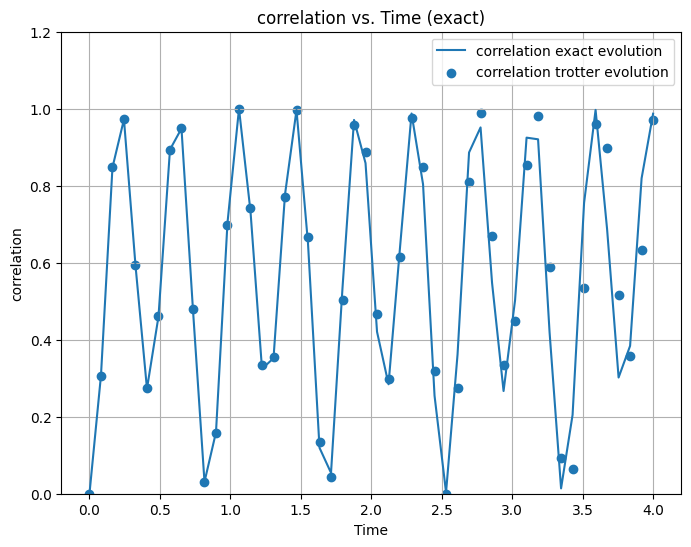

In [36]:
# Plot correlations

plt.figure(figsize=(8, 6))
plt.plot(times, correlations_exact, label="correlation exact evolution")
plt.scatter(times, correlations_trotter, label="correlation trotter evolution")
plt.xlabel("Time")
plt.ylabel("correlation")
plt.ylim([0, 1.2])
plt.title("correlation vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()



In [37]:


# dev = qml.device("default.qubit", wires=int(np.log2(H.shape[0])))
# @qml.qnode(dev)

# def pennylane_evo(t, n, v):
#     b=int(np.log2(H.shape[0]))
#     for i in range (0, b):
#         if v >= (2**(b-i-1)):
#             qml.PauliX(wires=(i))
#             v=v-2**(b-i-1)
#         # print(v)
#     qml.ApproxTimeEvolution(H_ps.hamiltonian(), t, n)
#     return qml.state()


### Check which initial states evolve
`get_initial_state` returns the state associated to the input. The latter indicates unambiguously the computation base vector, defined by all zeros excepts for the value at the position v-th, which has to be 1. 

In [38]:
#checks for every inital state which one evolves
dim = 2**n_qubits
def get_initial_state(v):
    initial_state = np.zeros(dim, dtype=complex)
    initial_state[v] = 1
    return initial_state

print(initial_state.shape)

def exact_evo_all(t, v, H):
    initial_state=get_initial_state(v)
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t))
    evolved_state = U @ initial_state
    overlap=np.abs(np.vdot(evolved_state, initial_state))**2
    return overlap

for v in range(0,2**n_qubits):
    print(v, exact_evo_all(5, v, H))

(16,)
0 1.0
1 1.0000000000000004
2 1.0000000000000004
3 0.9740390055370834
4 1.0000000000000004
5 1.0
6 1.0
7 0.9999999999999993
8 1.0000000000000004
9 1.0
10 1.0
11 0.9999999999999993
12 0.9740390055370832
13 0.9999999999999996
14 1.0
15 0.9999999999999984


## Clustering

In [39]:
# Set H = 0 for now just to make sure that we are not accidentally using the old one with fixed parameters
H = 0

j=2
eps=1.0
g=1.0
V=1.0

v = 12#12 #initial state
n_qubits = 4*j

# Initial state

dim = 2**n_qubits
initial_state = np.zeros(dim, dtype=complex)
initial_state[v] = 1


print(initial_state.shape)
print(n_qubits)

(256,)
8


In [40]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
#from sklearn_extra.cluster import KMedoids


In [41]:
# exact time evolution
def exact_evo_new(H, t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t))
    evolved_state = U @ initial_state
    return evolved_state

def get_ham_matrix_form(j, eps, g, V):
    H_sec = agassi_hamiltonian(j, eps, g, V)
    H_ps = qml.jordan_wigner(H_sec, ps=True)
    order = list(range(n_qubits))
    for i in range(0,n_qubits):
        order[i]=i
    H = qml.matrix(H_ps, wire_order=order)
    return H

def get_correlations_from_ham(H, times, evo_func=exact_evo_new):
    correlations = []
    for t in times:
        result = evo_func(H, t)
        correlation = correlation_function(result)
        correlations.append(correlation)
    return correlations

def get_g_V_from_sigma_xi(sigma, xi, eps, j):
    g = sigma * (2*j-1) / eps
    V = xi * (2*j-1) / eps
    return g, V

# get correlations from parameter lists
def get_correlations_from_param_list(times, g_list, V_list, verbose=False):
    correlations_list = []
    i = 0
    n_tot = len(g_list) * len(V_list)
    for g in g_list:
        for V in V_list:
            H = get_ham_matrix_form(j, eps, g, V)
            correlations = get_correlations_from_ham(H, times)

            # do fourier transform of correlations if wanted (uncomment otherwise)
            # correlations = np.fft.fft(correlations)
            # correlations = np.abs(correlations)

            correlations_list.append(correlations)
            i += 1
            if verbose:
                if i % 10 == 0:
                    print(f"Progress: {i}/{n_tot}")
                # print(j, eps, g, V, len(correlations))
    return correlations_list


In [42]:
# sigma_list = np.linspace(0, 2, 10)
# xi_list = np.linspace(0, 2, 10)
sigma_list = np.linspace(0.6, 1.8, 20)
xi_list = np.linspace(0.6, 1.8, 20)
times = np.linspace(0, t_max, 10)



g_list, V_list = get_g_V_from_sigma_xi(sigma_list, xi_list, eps, j)



In [43]:

correlations_list = get_correlations_from_param_list(times, g_list, V_list, verbose=True)
correlations_list = np.array(correlations_list)
correlations_list = np.real(correlations_list)

print(correlations_list.shape)


Progress: 10/400
Progress: 20/400
Progress: 30/400
Progress: 40/400
Progress: 50/400
Progress: 60/400
Progress: 70/400
Progress: 80/400
Progress: 90/400
Progress: 100/400
Progress: 110/400
Progress: 120/400
Progress: 130/400
Progress: 140/400
Progress: 150/400
Progress: 160/400
Progress: 170/400
Progress: 180/400
Progress: 190/400
Progress: 200/400
Progress: 210/400
Progress: 220/400
Progress: 230/400
Progress: 240/400
Progress: 250/400
Progress: 260/400
Progress: 270/400
Progress: 280/400
Progress: 290/400
Progress: 300/400
Progress: 310/400
Progress: 320/400
Progress: 330/400
Progress: 340/400
Progress: 350/400
Progress: 360/400
Progress: 370/400
Progress: 380/400
Progress: 390/400
Progress: 400/400
(400, 10)


In [44]:
correlations_list.shape

(400, 10)

In [45]:
kmeans = KMeans(n_clusters=2, random_state=2435)
#kmeans=KMedoids(n_clusters=2, metric='manhattan', random_state=2435)
#kmeans = DBSCAN(eps=0.5, min_samples=1)
# correlations_list = StandardScaler().fit_transform(correlations_list)
kmeans.fit(correlations_list)

KMeans(n_clusters=2, random_state=2435)

In [46]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

#print("Cluster Centers:\n", centroids)
print("Assigned Labels:\n", labels)

Assigned Labels:
 [0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1
 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1
 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0
 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1
 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1
 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1
 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1
 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1
 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1
 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0]


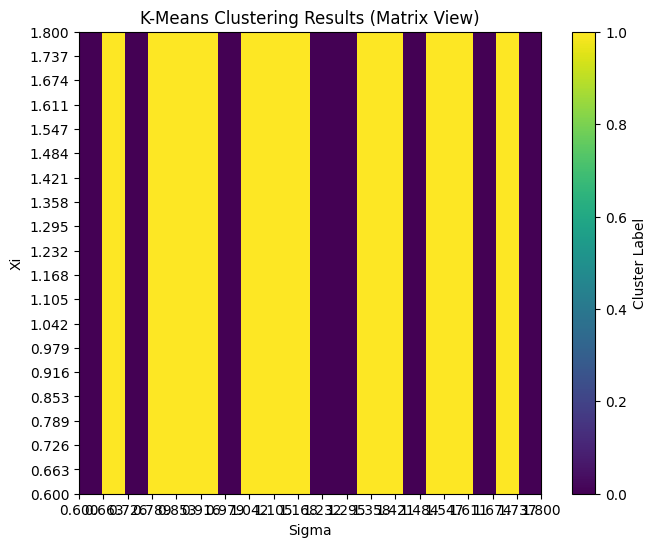

In [47]:
labels_matrix = labels.reshape(len(sigma_list), len(xi_list))

plt.figure(figsize=(8, 6))
plt.imshow(labels_matrix, cmap='viridis', origin='lower', extent=[sigma_list.min(), sigma_list.max(), xi_list.min(), xi_list.max()])
plt.colorbar(label="Cluster Label")
plt.xlabel("Sigma")
plt.ylabel("Xi")
plt.title("K-Means Clustering Results (Matrix View)")
plt.xticks(sigma_list)  # Label x-axis with sigma values
plt.yticks(xi_list)     # Label y-axis with xi values
plt.grid(visible=False) # Hide grid lines for a clean look
plt.show()

In [48]:
# sigma_mesh, xi_mesh = np.meshgrid(sigma_list, xi_list)
# labels_2D = labels.reshape(len(sigma_list), len(xi_list))  # Reshape to match grid

# plt.figure(figsize=(8, 6))
# plt.contourf(sigma_mesh, xi_mesh, labels_2D, cmap='viridis', alpha=0.6)
# plt.colorbar(label="Cluster Label")
# plt.xlabel("Sigma")
# plt.ylabel("Xi")
# plt.title("K-Means Clustering of Correlations")
# plt.show()

In [49]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# dimred = TSNE(n_components=2, perplexity=60, random_state=42)
dimred = PCA(n_components=2)
# correlations_reduced = dimred.fit_transform(correlations_list)

# plt.figure(figsize=(8, 6))
# plt.scatter(correlations_reduced[:, 0], correlations_reduced[:, 1], c=labels, cmap='viridis', edgecolors='k')
# plt.colorbar(label="Cluster Label")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.title("t-SNE Visualization of Correlations")
# plt.show()

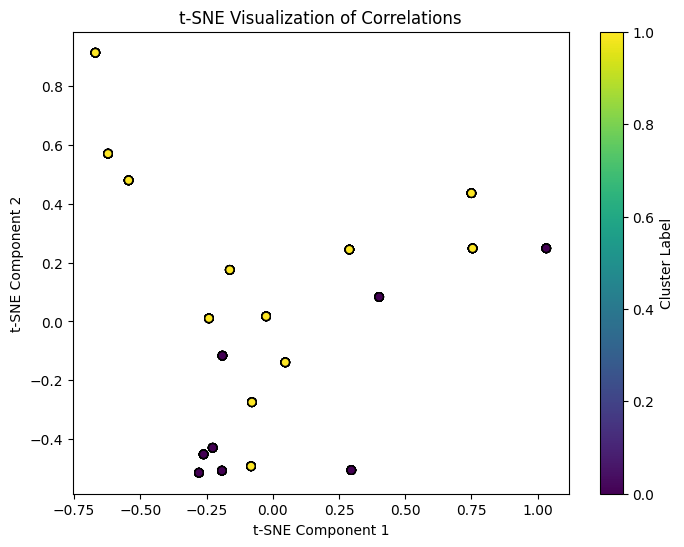

In [50]:
correlations_reduced = dimred.fit_transform(correlations_list)
plt.figure(figsize=(8, 6))
plt.scatter(correlations_reduced[:, 0], correlations_reduced[:, 1], c=labels, cmap='viridis', edgecolors='k')
plt.colorbar(label="Cluster Label")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Correlations")
plt.show()

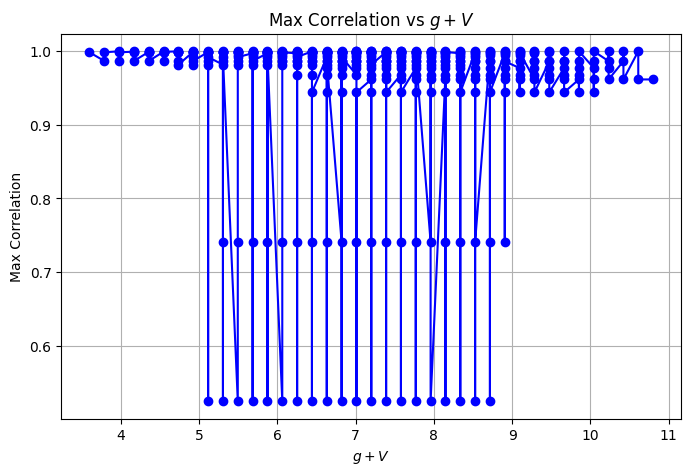

In [51]:
import numpy as np
import matplotlib.pyplot as plt

corr_max = np.max(correlations_list, axis=1)
g_mesh, V_mesh = np.meshgrid(g_list, V_list)

# Compute g + V for each pair
gV_values = g_mesh.flatten() + V_mesh.flatten()
corr_max_values = corr_max.flatten()

# Sort by g+V values
sorted_indices = np.argsort(gV_values)
gV_sorted = gV_values[sorted_indices]
corr_sorted = corr_max_values[sorted_indices]

# Plot the result
plt.figure(figsize=(8, 5))
plt.plot(gV_sorted, corr_sorted, marker='o', linestyle='-', color='b')
plt.xlabel(r'$g + V$')
plt.ylabel('Max Correlation')
plt.title('Max Correlation vs $g + V$')
plt.grid(True)
plt.show()

In [52]:
# get correlations from parameter lists
def get_max_correlations_from_param_list(times, g_list, V_list):
    n_tot = len(g_list) * len(V_list)
    correlations_list = np.empty((len(g_list), len(V_list)))
    i=0
    k=0
    l=0
    max_correlations_list = np.empty((len(g_list), len(V_list)))
    for i in range(len(g_list)):  
        for k in range(len(V_list)):
            H = get_ham_matrix_form(j, eps, g_list[i], V_list[k])
            correlations=0
            correlations = get_correlations_from_ham(H, times)
            
            # do fourier transform of correlations if wanted (uncomment otherwise)
            # correlations = np.fft.fft(correlations)
            # correlations = np.abs(correlations)
            max_correlations_list[i][k]=np.mean(correlations)#np.mean(correlations)#np.max(correlations)
            l=l+1
            if l % 1 == 0:
                    print(f"Progress: {l}/{n_tot}")
                # print(j, eps, g, V, len(correlations))
    
    corrs = np.array(max_correlations_list)
    grad_V, grad_g = np.gradient(corrs)
    grad_norm = np.sqrt(grad_V**2 + grad_g**2)
    return grad_norm

    # return max_correlations_list
    

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

max_correlations_list_full = []
for i in range(0,50):
    print("#"*100)
    print("Iteration: ", i)
    random_state = np.random.rand(dim) + 1j * np.random.rand(dim)
    initial_state = random_state / np.linalg.norm(random_state)
    max_correlations_list_=get_max_correlations_from_param_list(times, g_list, V_list)

    max_correlations_list_full.append(max_correlations_list_)

####################################################################################################
Iteration:  0
Progress: 1/400


/var/folders/_h/zshrjsxs42s1yscqytrdy2q00000gn/T/ipykernel_20645/1490642777.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  max_correlations_list[i][k]=np.mean(correlations)#np.mean(correlations)#np.max(correlations)


Progress: 2/400
Progress: 3/400
Progress: 4/400
Progress: 5/400
Progress: 6/400
Progress: 7/400
Progress: 8/400
Progress: 9/400
Progress: 10/400
Progress: 11/400
Progress: 12/400
Progress: 13/400
Progress: 14/400
Progress: 15/400
Progress: 16/400
Progress: 17/400
Progress: 18/400
Progress: 19/400
Progress: 20/400
Progress: 21/400
Progress: 22/400
Progress: 23/400
Progress: 24/400
Progress: 25/400
Progress: 26/400
Progress: 27/400
Progress: 28/400
Progress: 29/400
Progress: 30/400
Progress: 31/400
Progress: 32/400
Progress: 33/400
Progress: 34/400
Progress: 35/400
Progress: 36/400
Progress: 37/400
Progress: 38/400
Progress: 39/400
Progress: 40/400
Progress: 41/400
Progress: 42/400
Progress: 43/400
Progress: 44/400
Progress: 45/400
Progress: 46/400
Progress: 47/400
Progress: 48/400
Progress: 49/400
Progress: 50/400
Progress: 51/400
Progress: 52/400
Progress: 53/400
Progress: 54/400
Progress: 55/400
Progress: 56/400
Progress: 57/400
Progress: 58/400
Progress: 59/400
Progress: 60/400
Progr

In [54]:
print(np.array(max_correlations_list_full).shape)

(50, 20, 20)


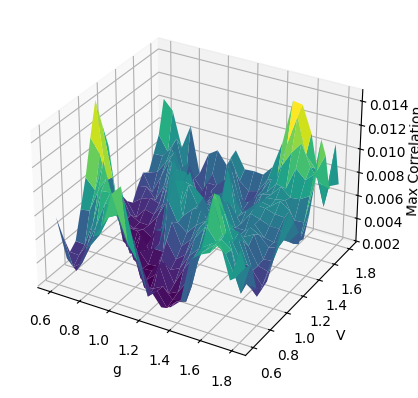

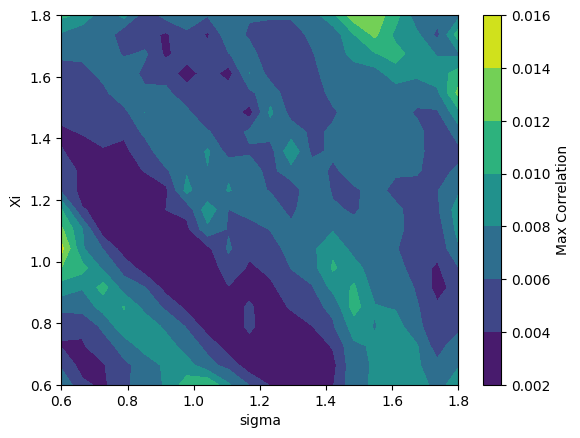

In [55]:


max_correlations_list = np.array(max_correlations_list_full)
max_correlations_list = np.mean(max_correlations_list, axis=0)


# Create a meshgrid for g and V
Sigma, Xi = np.meshgrid(sigma_list, xi_list)

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(Sigma, Xi, max_correlations_list.T, cmap='viridis')

# Add labels
ax.set_xlabel('g')
ax.set_ylabel('V')
ax.set_zlabel('Max Correlation')

# Show the plot
plt.show()

# Create a meshgrid for g and V
Sigma, Xi = np.meshgrid(sigma_list, xi_list)

# Create the 2D color plot
plt.figure()
plt.contourf(Sigma, Xi, max_correlations_list.T, cmap='viridis')
plt.colorbar(label='Max Correlation')

# Add labels
plt.xlabel('sigma')
plt.ylabel('Xi')

# plt.xlim([0.4, 2.0])
# plt.ylim([0.4, 2.0])

# Show the plot
plt.show()

In [56]:
# # Create a grid of (sigma, xi) pairs
# sigma_values, xi_values = np.meshgrid(sigma_list, xi_list)
# sigma_flat = sigma_values.flatten()  # Convert to 1D array
# xi_flat = xi_values.flatten()        # Convert to 1D array

# # Plot scatter points with cluster labels as colors
# plt.figure(figsize=(8, 6))
# plt.scatter(sigma_flat, xi_flat, c=labels, cmap='viridis', edgecolors='k', s=100.)
# plt.colorbar(label="Cluster Label")
# plt.xlabel("Sigma")
# plt.ylabel("Xi")
# plt.title("K-Means Clustering of Correlations")
# plt.show()

In [57]:
# corr_times = np.linspace(0, t_max, 10)

# def get_ham_matrix_form(j, eps, g, V):
#     H_sec = agassi_hamiltonian(j, eps, g, V)
#     H_ps = qml.jordan_wigner(H_sec, ps=True, wire_map={0: 0, 1: 1, 2: 2, 3: 3})
#     order = list(range(n_qubits))
#     for i in range(0,n_qubits):
#         order[i]=i
#     H = qml.matrix(H_ps, wire_order=order)
#     return H

# H = get_ham_matrix_form(j, eps, g, V)

# ab = get_correlations_from_ham(H, corr_times, evo_func=exact_evo_new)
# print(len(ab))

In [58]:
# def get_correlations_from_params

## Extra